## 1. Is it a fruit?

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai icrawler --use-deprecated=legacy-resolver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.8/234.8 kB 5.3 MB/s eta 0:00:00


The basic steps we'll take are:

1. Use icrawler to search for images of the categories you specified
1. Fine-tune a pretrained neural network to recognise these groups
1. Try running this model on a picture of a sample downloaded image and see if it works.

## Step 1: Download images of your categories

In [2]:
from icrawler import ImageDownloader
from icrawler.builtin import GoogleImageCrawler
from icrawler.builtin.google import GoogleFeeder, GoogleParser

class MyDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(MyDownloader, self).get_filename(task, default_ext)
        filename = filename.split(".")[0]
        return self.prefix + filename + ".png"

class MyCrawler(GoogleImageCrawler):
    def __init__(self, feeder_cls=GoogleFeeder, parser_cls=GoogleParser, downloader_cls=MyDownloader, prefix="", *args, **kwargs):
        super().__init__(feeder_cls, parser_cls, downloader_cls, *args, **kwargs)
        self.downloader.prefix = prefix

Let's start by creating a search function to search for any photo online with icrawler and downloading the searched image into your working files.

In [3]:
# We'll define a search_images function for the sake of ease

def search_images(term, max_images=30, folder_name="."):
    print(f"Searching for '{term}'")
    crawler = MyCrawler(
        prefix=term,
        storage={'root_dir': folder_name}, 
    )
    crawler.crawl(keyword=term, max_num=max_images)

Let's start by searching for an apple photo and seeing what kind of result we get.

In [4]:
search_images("apple_fruit", 2)

Searching for 'apple_fruit'


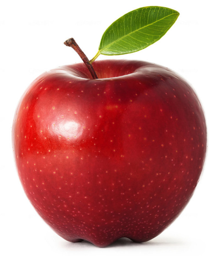

In [5]:
from fastai.vision.all import *
im = Image.open("apple_fruit000001.png")
# icrawler names the downloaded photos from 000001 to 999999
im.to_thumb(256,256)

Now let's do the same with "banana photos":

In [6]:
search_images("banana_fruit", 1)

Searching for 'banana_fruit'


Let's look at the banana photo:

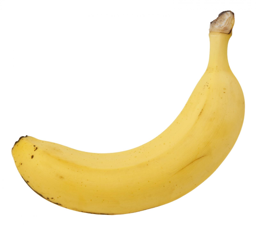

In [7]:
im = Image.open("banana_fruit000001.png")
im.to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of different categories photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [8]:
## !! IMPORTANT
# This represents the number of photos that'll be downloaded for each category.
# If you don't want to wait you can lower this number so less images will be downloaded.
# Having less images to train on may lead to worse neural network performance.
no_of_photos = 20 # Default is 20

searches = 'apple_fruit','banana_fruit','pear_fruit','strawberry_fruit','kiwi_fruit'

path = Path('dataset')
from time import sleep

for o in searches:
    dest = (path/o)
    print(f'This is dest, {dest}')
    dest.mkdir(exist_ok=True, parents=True)
    search_images(f"{o} photo", no_of_photos, dest)
    sleep(10)  # Pause between searches to avoid over-loading server
    search_images(f"{o} table photo", no_of_photos, dest)
    sleep(10)
    search_images(f"{o} supermarket photo", no_of_photos, dest) 
    # Changed this to get "night photo" instead of "shade photo" since the original would cause paint tones to be downloaded 
    sleep(10)
    print(f"Photos of {o} completed!")

resize_images(path, max_size=400, dest=path, recurse=True)
print(f"Photos resized!")

This is dest, dataset/apple_fruit
Searching for 'apple_fruit photo'
Searching for 'apple_fruit table photo'
Searching for 'apple_fruit supermarket photo'
Photos of apple_fruit completed!
This is dest, dataset/banana_fruit
Searching for 'banana_fruit photo'
Searching for 'banana_fruit table photo'
Searching for 'banana_fruit supermarket photo'
Photos of banana_fruit completed!
This is dest, dataset/pear_fruit
Searching for 'pear_fruit photo'
Searching for 'pear_fruit table photo'
Searching for 'pear_fruit supermarket photo'
Photos of pear_fruit completed!
This is dest, dataset/strawberry_fruit
Searching for 'strawberry_fruit photo'
Searching for 'strawberry_fruit table photo'
Searching for 'strawberry_fruit supermarket photo'
Photos of strawberry_fruit completed!
This is dest, dataset/kiwi_fruit
Searching for 'kiwi_fruit photo'
Searching for 'kiwi_fruit table photo'
Searching for 'kiwi_fruit supermarket photo'
Photos of kiwi_fruit completed!


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Photos resized!


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

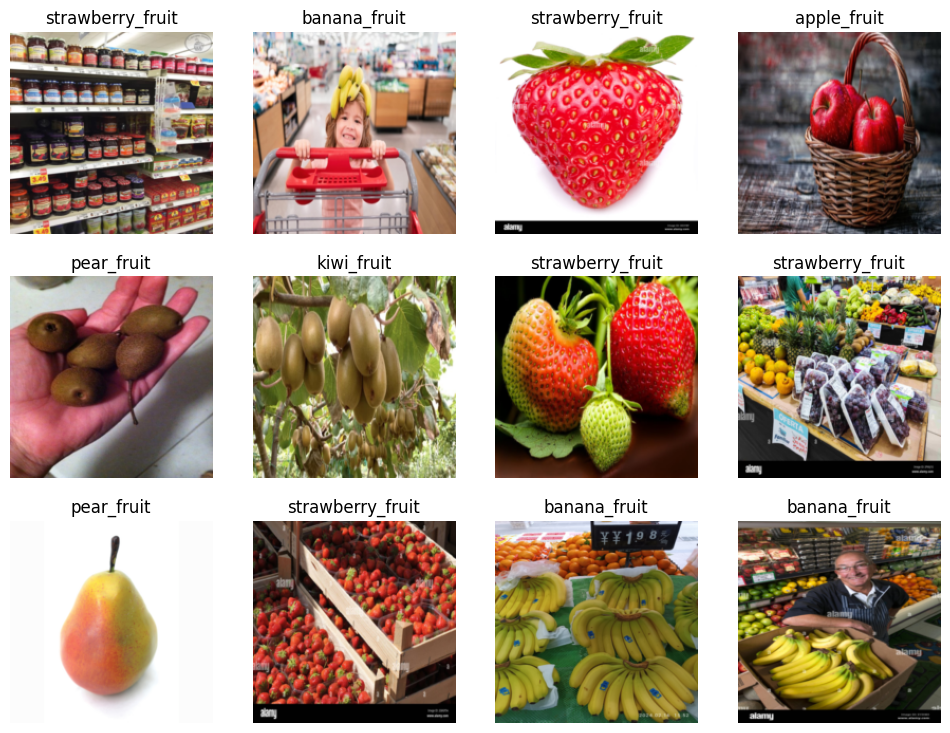

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 121MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.225479,1.122183,0.482143,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.024178,0.919627,0.339286,00:01
1,0.784499,0.789393,0.321429,00:01
2,0.578793,0.697824,0.285714,00:01
3,0.449664,0.660017,0.214286,00:01
4,0.345851,0.802887,0.250000,00:01
5,0.277915,0.883343,0.214286,00:01
6,0.226606,0.900820,0.214286,00:01
7,0.193268,0.907426,0.196429,00:01
8,0.164603,0.890171,0.196429,00:01
9,0.140667,0.899284,0.196429,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that apple we downloaded at the start:

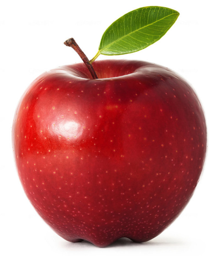

In [12]:
im = Image.open("/kaggle/working/apple_fruit000001.png")
im.to_thumb(256,256)

In [13]:
# Check for category index
classes = list(learn.dls.vocab)

print(classes)

['apple_fruit', 'banana_fruit', 'kiwi_fruit', 'pear_fruit', 'strawberry_fruit']


In [14]:
predicted_class,_,probs = learn.predict(im)
# is_bird,_,probs = learn.predict(PILImage.create('forest000001.png'))
print(f"This is a: {predicted_class}.")
predicted_idx = classes.index(predicted_class)
# print(f"Probability it's a {predicted_class}: {probs[predicted_idx]:.4f}")
for idx, ele in enumerate(classes):
    print(f"Probability it's a {ele}: {probs[idx]:.4f}")

This is a: apple_fruit.
Probability it's a apple_fruit: 0.9999
Probability it's a banana_fruit: 0.0000
Probability it's a kiwi_fruit: 0.0000
Probability it's a pear_fruit: 0.0000
Probability it's a strawberry_fruit: 0.0000


In [15]:
#Export the model

learn.export('model.pkl')

Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!